In [1]:
import torch.nn.functional as F
from torchmetrics.classification import MultilabelF1Score, MultilabelPrecisionRecallCurve
import torch
from torch import nn
from torchvision.transforms import transforms as T
from PIL import Image
import kornia as K
import pandas as pd
import json
import sys
sys.path.append("../classification/scripts")
from augmentation import PreProcess, DataAugmentation
from service import get_class_decoder
from model import image_to_tensor, Dataset
from os.path import join
import os
IMAGE_DIR = "/home/timssh/ML/TAGGING/data"
SOURCE = "/home/timssh/ML/TAGGING/source"


In [2]:
path_models = {
    # 'tits' : '/home/timssh/ML/TAGGING/source/wandb/tits/version_2_val_eff/checkpoints/epoch=61-step=2356.pt',
    # 'pose' : '/home/timssh/ML/TAGGING/source/wandb/pose/version_0_train_eff/checkpoints/epoch=19-step=1180.pt',
    'tits' : '/home/timssh/ML/TAGGING/source/wandb/tits/version_6_val_eff/checkpoints/epoch=69-step=3360.pt',
    'pose' : '/home/timssh/ML/TAGGING/source/wandb/pose/version_4_val_eff/checkpoints/epoch=32-step=2178.pt',
    'hair' : '/home/timssh/ML/TAGGING/source/wandb/hair/version_0_train_eff/checkpoints/epoch=18-step=836.pt'


}
path_model = path_models['pose']
cat = 'pose'


Pre = PreProcess(False)
Aug = DataAugmentation()
Aug.eval()
ToTensor = T.ToTensor()

model = torch.jit.load(path_model, 'cuda')

model.eval()

category = path_model.split('/')[-4]
num2label, _, _, _ = get_class_decoder(category)
_, __train_pd, __val_pd, weights = get_class_decoder(cat)
print(category)
data = pd.concat([__train_pd, __val_pd])
data.head()

[5.356084996780425, 5.530585106382978, 5.156850588964662, 7.514001806684734, 7.460089686098654, 5.833099579242637]
[5.356084996780425, 5.530585106382978, 5.156850588964662, 7.514001806684734, 7.460089686098654, 5.833099579242637]
pose


,dir,pose_69,pose_cowgirl,pose_doggy,pose_missionary,pose_reverse_cowgirl,pose_spooning
0,/home/timssh/ML/TAGGING/data/pose/spooning/fat...,0,0,0,0,0,1
1,/home/timssh/ML/TAGGING/data/pose/spooning/spo...,0,0,0,0,0,1
2,/home/timssh/ML/TAGGING/data/pose/noise/cummin...,0,0,0,0,0,0
3,/home/timssh/ML/TAGGING/data/pose/spooning/spo...,0,0,0,0,0,1
4,/home/timssh/ML/TAGGING/data/pose/spooning/fat...,0,0,0,0,0,1


/home/timssh/ML/TAGGING/data/pose/doggy/doggy-style-porn-720/picture/73aa12512a75a91d971a6330fa40c960.jpeg
{'0': 'pose_69', '1': 'pose_cowgirl', '2': 'pose_doggy', '3': 'pose_missionary', '4': 'pose_reverse_cowgirl', '5': 'pose_spooning'}
tensor([[0.0200, 0.0310, 0.9790, 0.0170, 0.0270, 0.0200]], device='cuda:0',
       grad_fn=<RoundBackward1>)
armax tensor(0.9790, device='cuda:0', grad_fn=<MaxBackward1>) pose_doggy


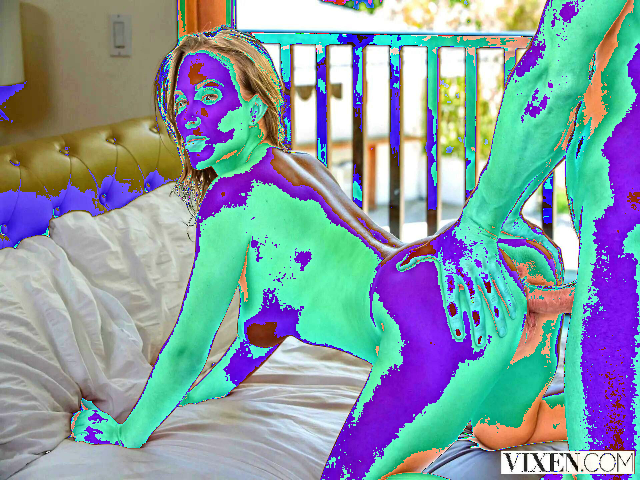

In [3]:
ji = 25

def get_res(ser):
    img = ser['dir']
    image = Image.open(img)
    image = ToTensor(image)
    print(ser['dir'])
    image = Pre(image.to(torch.float))
    image = Aug(image)
    ret_ = torch.round(torch.sigmoid(model(image.to("cuda"))), decimals=3)
    print(num2label)
    print(ret_)
    print('armax', ret_.max(), num2label[str(int(ret_.argmax()))])
    return T.ToPILImage()(image[0])

ser = data.iloc[ji]
get_res(ser)

In [5]:
def get_new_df(num2label, model, data):
    columns = list(num2label.values())
    columns.append('path')
    list2pd = []
    for i in range(len(data)):
        if i % 1000 == 0:
            print(i)
        d = {}
        ser = data.iloc[i]
        img = ser['dir']
        image = Image.open(img)
        image = ToTensor(image)
        image = Pre(image.to(torch.float))
        with torch.no_grad():
            ret_ = torch.round(torch.sigmoid(model(image.to("cuda"))), decimals=2)
            ret_ = ret_.to("cpu")[0]
            d['dir'] = img
            for i in range(len(num2label)):
                d[num2label[str(i)]] = float(ret_[i])
        list2pd.append(d)
    new_df = pd.DataFrame(list2pd)

    return new_df

In [6]:
new_df = get_new_df(num2label, model, data)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [19]:
yh_list = torch.tensor(new_df.iloc[:,1:].values)
y_list = torch.tensor(data.iloc[:,1:].values)

In [14]:
# with torch.no_grad():
#     y_list, yh_list = [], []
#     for index, xy in enumerate(dataloader):
#         # print(index)
#         x = get_x(xy[0])
#         y = get_y(xy[1])
#         yh = model(x)
#         y = y.to('cpu')
#         yh = torch.round(torch.sigmoid(yh).to('cpu'),decimals=2)
#         y_list.append(y[0])
#         yh_list.append(yh)

In [15]:
# y_list, yh_list = torch.cat(y_list, dim=0), torch.cat(yh_list, dim=0)

In [21]:
yh_list[:10][yh_list[:10] > 0.5]

tensor([1., 1., 1., 1., 1., 1., 1., 1.])

In [26]:
t = yh_list[:10]
(t * t>0.5).int(), t

(tensor([[0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0, 1]], dtype=torch.int32),
 tensor([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1.]]))

In [20]:
y_list.shape, yh_list.shape

(torch.Size([12852, 6]), torch.Size([12852, 6]))

In [21]:
f1_1 = MultilabelF1Score(
            num_labels=6,
            average="none",
            threshold=0.5
        )
f1_2 = MultilabelF1Score(
            num_labels=6,
            average="none",
            threshold=0.99
        )

In [22]:
f1_1( yh_list,y_list), f1_2( yh_list,y_list)

(tensor([0.9977, 0.9961, 0.9964, 0.9972, 0.9984, 0.9984]),
 tensor([0.9953, 0.9867, 0.9913, 0.9943, 0.9976, 0.9978]))

In [23]:
curve = MultilabelPrecisionRecallCurve(6,)

In [24]:
precision, recall, thresholds = curve(yh_list,y_list.int())

In [25]:
precision, recall, thresholds

([tensor([0.9920, 0.9925, 0.9931, 0.9937, 0.9942, 0.9948, 0.9954, 0.9960, 0.9965,
          0.9971, 0.9977, 0.9983, 0.9988, 0.9988, 0.9988, 0.9994, 1.0000, 1.0000,
          1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]),
  tensor([0.9870, 0.9876, 0.9882, 0.9888, 0.9893, 0.9899, 0.9905, 0.9911, 0.9917,
          0.9923, 0.9929, 0.9935, 0.9935, 0.9935, 0.9934, 0.9946, 0.9952, 0.9970,
          0.9976, 0.9976, 0.9976, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982, 0.9982,
          0.9986, 1.0000]),
  tensor([0.9917, 0.9917, 0.9922, 0.9928, 0.9933, 0.9939, 0.9945, 0.9950, 0.9950,
          0.9956, 0.9961, 0.9967, 0.9972, 0.9972, 0.9978, 0.9983, 0.9983, 0.9989,
          0.9989, 0.9989, 0.9989, 0.9989, 0.9994, 1.0000, 1.0000]),
  tensor([0.9943, 0.9943, 0.9951, 0.9951, 0.9959, 0.9968, 0.9968, 0.9976, 0.9976,
          0.9976, 0.9984, 0.9992, 0.9991, 1.0000]),
  tensor([0.1512, 0.2480, 0.4128, 0.5958, 0.7614, 0.8645, 0.9083, 0.9414, 0.9575,
          0.9657, 0.9717, 0.9794, 0.9833, 0.9857, 0.98

In [26]:
fscore=[]
for i in range(6):
    fscore.append((2 * precision[i] * recall[i]) / (precision[i] + recall[i]))

In [37]:
i = 0
fscore[i], fscore[i].argmax(), thresholds[i]

(tensor([0.9960, 0.9960, 0.9962, 0.9965, 0.9968, 0.9971, 0.9974, 0.9977, 0.9980,
         0.9983, 0.9986, 0.9988, 0.9991, 0.9988, 0.9986, 0.9986, 0.9985, 0.9983,
         0.9980, 0.9977, 0.9968, 0.9953, 0.9365, 0.0000]),
 tensor(12),
 tensor([0.2900, 0.3000, 0.3800, 0.3900, 0.4100, 0.4500, 0.4600, 0.5900, 0.6100,
         0.6900, 0.7200, 0.7500, 0.7600, 0.8800, 0.8900, 0.9100, 0.9300, 0.9400,
         0.9600, 0.9700, 0.9800, 0.9900, 1.0000], dtype=torch.float64))

: 

In [28]:
fscore

[tensor([0.9960, 0.9960, 0.9962, 0.9965, 0.9968, 0.9971, 0.9974, 0.9977, 0.9980,
         0.9983, 0.9986, 0.9988, 0.9991, 0.9988, 0.9986, 0.9986, 0.9985, 0.9983,
         0.9980, 0.9977, 0.9968, 0.9953, 0.9365, 0.0000]),
 tensor([0.9935, 0.9935, 0.9938, 0.9941, 0.9943, 0.9946, 0.9949, 0.9952, 0.9955,
         0.9958, 0.9961, 0.9964, 0.9961, 0.9958, 0.9955, 0.9961, 0.9964, 0.9973,
         0.9973, 0.9970, 0.9967, 0.9967, 0.9964, 0.9961, 0.9949, 0.9940, 0.9867,
         0.6029, 0.0000]),
 tensor([0.9958, 0.9956, 0.9958, 0.9961, 0.9964, 0.9967, 0.9969, 0.9972, 0.9969,
         0.9972, 0.9975, 0.9978, 0.9980, 0.9978, 0.9978, 0.9978, 0.9975, 0.9978,
         0.9972, 0.9969, 0.9961, 0.9952, 0.9913, 0.8727, 0.0000]),
 tensor([0.9972, 0.9968, 0.9972, 0.9968, 0.9972, 0.9976, 0.9972, 0.9976, 0.9972,
         0.9963, 0.9963, 0.9943, 0.9599, 0.0000]),
 tensor([0.2628, 0.3974, 0.5842, 0.7465, 0.8642, 0.9270, 0.9516, 0.9695, 0.9779,
         0.9821, 0.9853, 0.9892, 0.9912, 0.9924, 0.9932, 0.9948, 0.

In [31]:
f111 = (2 * precision * recall) / (precision + recall)
f111.shape

TypeError: can't multiply sequence by non-int of type 'list'

In [29]:
thresholds

[tensor([0.2900, 0.3000, 0.3800, 0.3900, 0.4100, 0.4500, 0.4600, 0.5900, 0.6100,
         0.6900, 0.7200, 0.7500, 0.7600, 0.8800, 0.8900, 0.9100, 0.9300, 0.9400,
         0.9600, 0.9700, 0.9800, 0.9900, 1.0000], dtype=torch.float64),
 tensor([0.3500, 0.3600, 0.3800, 0.4000, 0.4200, 0.4300, 0.4400, 0.4500, 0.4900,
         0.5000, 0.5200, 0.5500, 0.6000, 0.6200, 0.6400, 0.6800, 0.7700, 0.7900,
         0.8200, 0.8400, 0.8600, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800, 0.9900,
         1.0000], dtype=torch.float64),
 tensor([0.4500, 0.4600, 0.4800, 0.4900, 0.5900, 0.6500, 0.6900, 0.7400, 0.7700,
         0.8000, 0.8200, 0.8600, 0.8700, 0.8900, 0.9000, 0.9100, 0.9200, 0.9400,
         0.9500, 0.9600, 0.9700, 0.9800, 0.9900, 1.0000], dtype=torch.float64),
 tensor([0.5200, 0.6100, 0.6200, 0.7000, 0.7200, 0.8400, 0.8500, 0.9300, 0.9500,
         0.9600, 0.9800, 0.9900, 1.0000], dtype=torch.float64),
 tensor([0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800, 0.0900, 0.1000, 0.1100,
         0.1200

In [30]:
thresholds[f111.argmax(dim=1)]

NameError: name 'f111' is not defined

In [104]:
for score in fscore:
    print(score.argmax())

tensor(3)
tensor(2)
tensor(6)
tensor(1)
tensor(3)
tensor(9)


In [94]:
batch = ds[1110][1], ds[2210][1], ds[543][1], ds[435][1]
batch

(1, 3, 0, 0)

In [95]:
y = F.one_hot(torch.tensor(
            batch), num_classes=4+1)[:, :-1].float()
y

tensor([[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

tensor([[-0.5000,  0.5000, -0.5000, -0.5000],
        [-0.5000, -0.5000, -0.5000,  0.5000],
        [ 0.5000, -0.5000, -0.5000, -0.5000],
        [ 0.5000, -0.5000, -0.5000, -0.5000]])

In [ ]:
MultilabelF1Score(
            num_labels=4,
            average="macro",
        ).to("cuda")

In [ ]:
for i in range(len(data)):
    ser = data.iloc[1]
    os.path.join(ser['class'], ser['path'], ser['name'])


In [14]:
with open('/home/timssh/ML/TAGGING/CLS/classification/source/pose/data.json') as f:
    data = json.load(f)

In [19]:
d = { v:k for k,v in  data.items()}
data

{'reverse_cowgirl': 0,
 '69': 1,
 'cowgirl': 2,
 'missionary': 3,
 'spooning': 4,
 'noise': 5}

: 

In [15]:
data["label"].unique()[data["label"].unique() != 'noise']

array(['reverse_cowgirl', '69', 'cowgirl', 'missionary', 'spooning'],
      dtype=object)

In [2]:
type([])

list

In [15]:
from glob import glob

In [30]:
experiment_name = '/home/timssh/ML/TAGGING/source/comet/pose/version_2_train'
glob(os.path.join(experiment_name,'checkpoints/*.ckpt'))

['/home/timssh/ML/TAGGING/source/comet/pose/version_2_train/checkpoints/epoch=31-step=18720.ckpt']